In [1]:
import pandas

df = pandas.read_csv('Raw Data.csv')
df

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,-0.000141,0.081872,-0.055213,0.071132,0.121702
1,0.009856,-0.048625,-0.027615,0.068886,0.088726
2,0.019854,-0.070803,-0.004574,0.047379,0.085316
3,0.029852,0.035135,-0.004842,-0.069368,0.077909
4,0.039850,0.048807,-0.033459,-0.114005,0.128448
...,...,...,...,...,...
3235,32.342933,-0.031662,-0.012572,0.048071,0.058918
3236,32.352931,0.010792,0.022236,-0.049985,0.055762
3237,32.362929,-0.017933,0.043227,-0.274667,0.278625
3238,32.372927,-0.047209,0.001571,-0.312831,0.316377


<AxesSubplot:xlabel='Time (s)'>

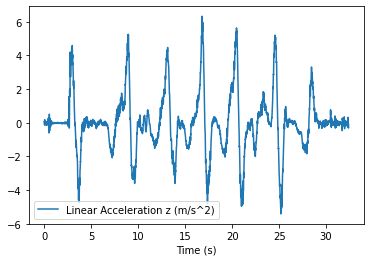

In [3]:
df.plot.line(x="Time (s)", y="Linear Acceleration z (m/s^2)")

## Calculating velocity and distance from z-axis acceleration and timesteps

Distance is (m):  19.952919557743094
Energy is (J):  124.60287901148602


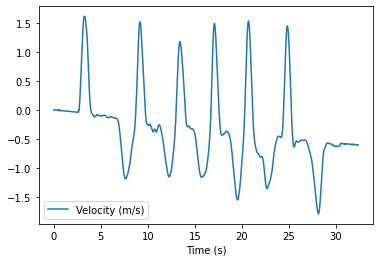

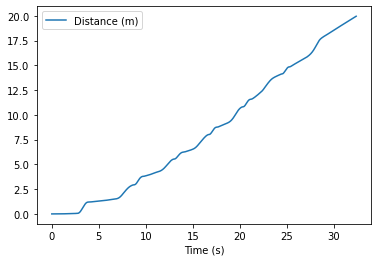

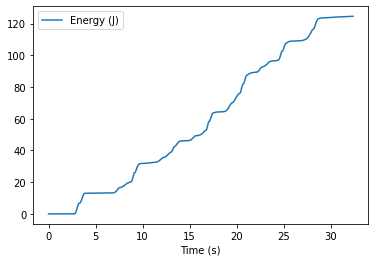

In [10]:
def get_velocity(acceleration: float, V0: float, delta_t: float):
    # a = (V1-V0) / t
    # V1 = a*t + V0
    return acceleration * delta_t + V0

def get_distance(delta_V: float, delta_t: float):
    # V = s/t
    # s = V*t
    return delta_V * delta_t

def get_energy_spent(mass: float, distance: float, acceleration: float):
    # A = F*s
    # F = m*a
    return mass * acceleration * distance

mass = 5
previous_time = 0.0
previous_velocity = 0.0
total_distance = 0.0
total_energy = 0.0
velocity_vec = [[]]
distance_vec = [[]]
energy_vec = [[]]

for index, row in df.iterrows():
    timestep = row["Time (s)"] - previous_time

    velocity = get_velocity(row["Linear Acceleration z (m/s^2)"], previous_velocity, timestep)
    velocity_vec.append([row["Time (s)"], velocity])

    distance_step = abs(get_distance(velocity, timestep))
    total_distance += distance_step
    distance_vec.append([row["Time (s)"], total_distance])

    energy_step = abs(get_energy_spent(mass, distance_step, row["Linear Acceleration z (m/s^2)"]))
    total_energy += energy_step
    energy_vec.append([row["Time (s)"], total_energy])

    previous_velocity = velocity
    previous_time = row["Time (s)"]

df_velocity = pandas.DataFrame(velocity_vec, columns=["Time (s)", "Velocity (m/s)"])
df_velocity.plot.line(x="Time (s)", y="Velocity (m/s)")
df_distance = pandas.DataFrame(distance_vec, columns=["Time (s)", "Distance (m)"])
df_distance.plot.line(x="Time (s)", y="Distance (m)")
df_distance = pandas.DataFrame(energy_vec, columns=["Time (s)", "Energy (J)"])
df_distance.plot.line(x="Time (s)", y="Energy (J)")
print("Distance is (m): ", total_distance)
print("Energy is (J): ", total_energy)